## Código para extraer la serie temporal de OMIE

In [ ]:
import requests
import pandas as pd
import os
import zipfile
from datetime import datetime

def download_omie_file(date, extensions=['1', '2']):
    file_type = "marginalpdbc"
    for ext in extensions:
        url = f"https://www.omie.es/es/file-download?parents=marginalpdbc&filename=marginalpdbc_{date}.{ext}"
        response = requests.get(url)
        if response.status_code == 200:
            filename = f"{file_type}_{date}.{ext}"
            with open(filename, 'wb') as file:
                file.write(response.content)
            return filename
    print(f"No se pudo descargar ningún archivo para {date}")
    return None

def process_omie_files(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date)
    all_data = []
    for date in date_range:
        file_date = date.strftime('%Y%m%d')
        for ext in ['1', '2']:
            filename = f"marginalpdbc_{file_date}.{ext}"
            if os.path.exists(filename):
                with open(filename, 'r', encoding='utf-8', errors='ignore') as file:
                    lines = file.readlines()
                    if not lines:
                        continue
                    for line in lines:
                        parts = line.strip().split(';')
                        if len(parts) >= 7 and parts[0] != "MARGINALPDBC":
                            try:
                                fecha = f"{parts[0]}-{parts[1]}-{parts[2]}"
                                hora = int(parts[3])
                                precio = float(parts[4])
                                all_data.append({'Fecha': fecha, 'Hora': hora, 'Precio': precio})
                            except ValueError:
                                continue
                break  # No intenta .2 si .1 ya se procesó
    return all_data

def download_zip(year, download_folder='zips'):
    url = f"https://www.omie.es/es/file-download?parents=marginalpdbc&filename=marginalpdbc_{year}.zip"
    os.makedirs(download_folder, exist_ok=True)
    zip_path = os.path.join(download_folder, f"marginalpdbc_{year}.zip")
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        return zip_path
    else:
        print(f"No se pudo descargar ZIP para {year}")
        return None

def extract_and_process_zip(zip_path, temp_folder='temp_files'):
    os.makedirs(temp_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_folder)

    data = []
    seen_dates = set()

    files = sorted(os.listdir(temp_folder))  # Asegura orden consistente: .1 antes que .2
    for file_name in files:
        if file_name.startswith("marginalpdbc") and file_name.endswith(('.1', '.2')):
            date_part = file_name.split('_')[1].split('.')[0]
            if date_part in seen_dates:
                continue  # Ya se procesó ese día con .1 o .2
            seen_dates.add(date_part)

            file_path = os.path.join(temp_folder, file_name)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    parts = line.strip().split(';')
                    if len(parts) >= 7 and parts[0] != "MARGINALPDBC":
                        try:
                            fecha = f"{parts[0]}-{parts[1]}-{parts[2]}"
                            hora = int(parts[3])
                            precio = float(parts[4])
                            data.append({'Fecha': fecha, 'Hora': hora, 'Precio': precio})
                        except ValueError:
                            continue
    return data

def process_all_years(years):
    all_data = []
    for year in years:
        zip_path = download_zip(year)
        if zip_path:
            year_data = extract_and_process_zip(zip_path)
            all_data.extend(year_data)
            for file in os.listdir('temp_files'):
                os.remove(os.path.join('temp_files', file))
    return all_data

# Parámetros
start_date = '2023-01-01'
end_date = '2025-04-10'
years_zip = list(range(2018, 2023))

# Procesar ZIPs
data_zip = process_all_years(years_zip)

# Descargar y procesar diarios
for date in pd.date_range(start=start_date, end=end_date):
    formatted_date = date.strftime('%Y%m%d')
    download_omie_file(formatted_date)

data_diario = process_omie_files(start_date, end_date)

# Combinar y ordenar
df_final = pd.DataFrame(data_zip + data_diario)
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'], format='%Y-%m-%d')
df_final['Hora'] = pd.to_numeric(df_final['Hora'], errors='coerce')
df_final = df_final.sort_values(by=['Fecha', 'Hora']).reset_index(drop=True)

# Guardar
df_final.to_csv('mercado_diario.csv', index=False)
print("Todos los datos procesados y guardados en mercado_diario.csv")


Todos los datos procesados y guardados en mercado_diario.csv


In [ ]:
import requests
import pandas as pd
import os
import zipfile
from datetime import datetime

# Asegúrate de que 'Fecha' es datetime antes del groupby
df_final=pd.read_csv('mercado_diario.csv')
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

# Agrupa por fecha (sin hora) y pon 'Fecha' como índice
df_diario = df_final.groupby(df_final['Fecha'].dt.date)['Precio'].mean().to_frame()
df_diario.index = pd.to_datetime(df_diario.index)


# (Opcional) Si quieres llamar explícitamente al índice:
df_diario.index.name = 'Fecha'
df_diario.to_csv('mercado_diario_bien.csv', float_format='%,3f')

ValueError: unsupported format character ',' (0x2c) at index 1

In [ ]:
df_diario

,Precio
Fecha,
2018-01-01,25.660000
2018-01-02,40.896250
2018-01-03,45.745000
2018-01-04,45.370417
2018-01-05,44.784167
...,...
2025-04-06,26.559167
2025-04-07,55.043333
2025-04-08,47.672083


## Análisis descriptivo

In [ ]:
df_diario.describe()

,Precio
count,2657.000000
mean,81.470718
std,58.826197
min,0.105000
25%,43.451667
50%,62.228333
75%,105.807500
max,542.779167


<Axes: xlabel='Fecha'>

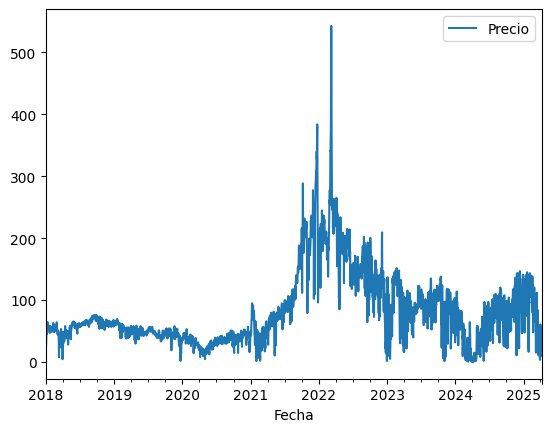

In [ ]:
df_diario.plot()

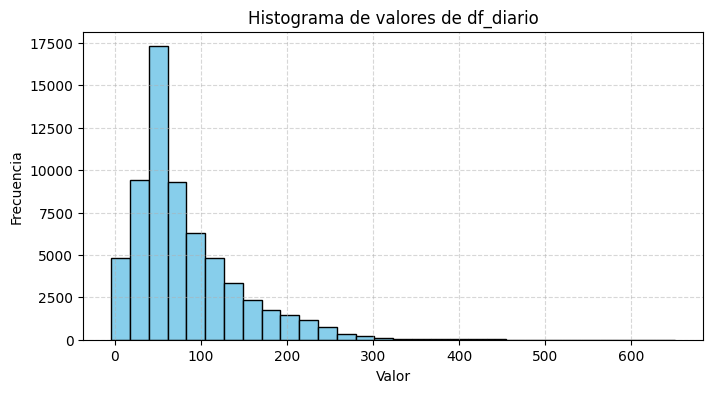

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df_diario.values, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de valores de df_diario')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

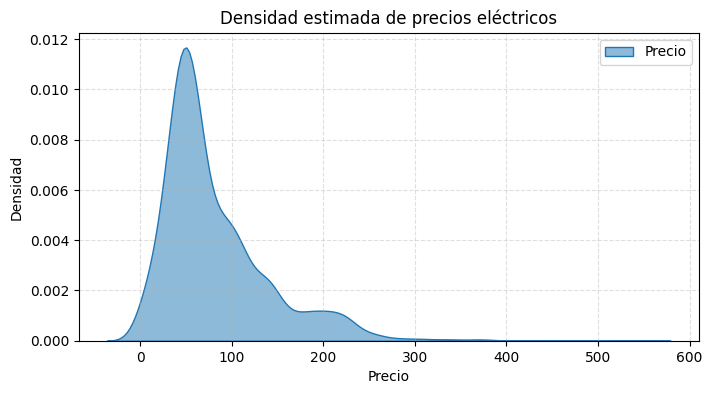

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.kdeplot(df_diario, fill=True, color='blue', alpha=0.5)
plt.title('Densidad estimada de precios eléctricos')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

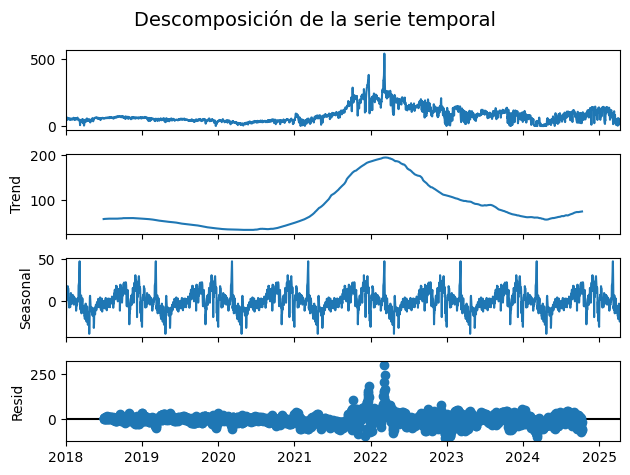

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_diario1 = df_diario.asfreq('D')
result = seasonal_decompose(df_diario1, model='additive', period=365)  # usa 'multiplicative' si hay escala

# Plot de los componentes
result.plot()
plt.suptitle('Descomposición de la serie temporal', fontsize=14)
plt.tight_layout()
plt.show()

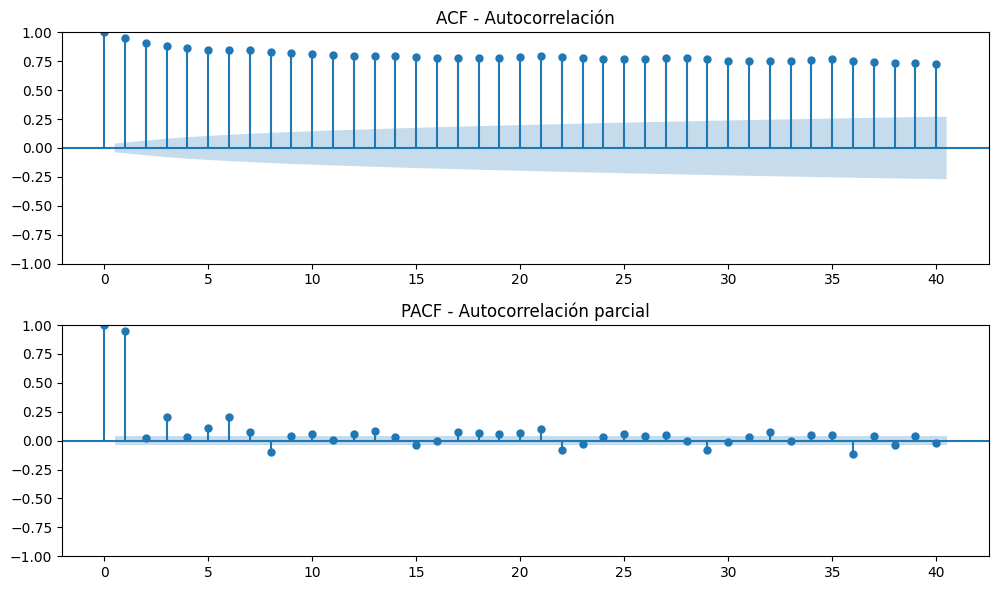

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Autocorrelación (ACF)
plot_acf(df_diario, ax=axes[0], lags=40)
axes[0].set_title('ACF - Autocorrelación')

# Autocorrelación parcial (PACF)
plot_pacf(df_diario, ax=axes[1], lags=40, method='ywm')  # ywm = método de Yule-Walker modificado
axes[1].set_title('PACF - Autocorrelación parcial')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(df_diario)
print("=== Prueba ADF ===")
print(f'Estadístico ADF: {resultado_adf[0]:.4f}')
print(f'Valor p: {resultado_adf[1]:.4f}')
for clave, valor in resultado_adf[4].items():
    print(f'Valor crítico {clave}: {valor:.4f}')

=== Prueba ADF ===
Estadístico ADF: -2.3036
Valor p: 0.1708
Valor crítico 1%: -3.4328
Valor crítico 5%: -2.8626
Valor crítico 10%: -2.5674


In [ ]:
from arch.unitroot import PhillipsPerron

resultado_pp = PhillipsPerron(df_diario.dropna())
print("\n=== Prueba Phillips-Perron ===")
print(resultado_pp.summary())


=== Prueba Phillips-Perron ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.270
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


NameError: name 'df_diario' is not defined

## Modelo SARIMA con Entrenamiento 2024, estacionalidad 7

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  452
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -1955.173
Date:                             Sun, 01 Jun 2025   AIC                           3922.346
Time:                                     15:03:11   BIC                           3947.015
Sample:                                 01-01-2024   HQIC                          3932.068
                                      - 03-27-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5742      0.064      9.022      0.000       0.449       0.699
ma.L1         -0.6781      

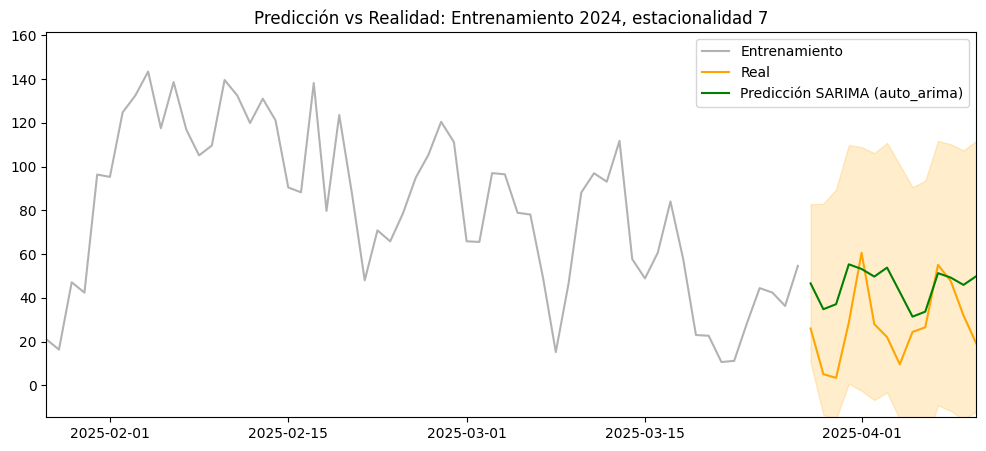

RMSE: 501.34


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Asume que tu DataFrame se llama df_diario y tiene columnas 'Fecha' y 'Precio'
df = df_diario.copy()
serie = df['Precio'].asfreq('D')
serie = serie[serie.index >= '2024-01-01']

split = int(len(serie) * 0.97)
train, test = serie.iloc[:-14], serie.iloc[-14:]

# Usar auto_arima para encontrar los mejores parámetros
auto_model = pm.auto_arima(train,
                           seasonal=True,
                           m=7,              # Periodo estacional (7 para datos diarios con estacionalidad semanal)
                           stepwise=True,    # Para acelerar la búsqueda
                           suppress_warnings=True,
                           trace=False)       # Para mostrar el progreso

print(auto_model.summary())

# Ajustar modelo SARIMA con los mejores parámetros encontrados
modelo = SARIMAX(train,
                 order=auto_model.order,
                 seasonal_order=auto_model.seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)
resultado = modelo.fit(disp=False)

# Predicción
pred = resultado.get_forecast(steps=len(test))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(train, label='Entrenamiento', color='grey', alpha=0.6)
plt.plot(test, label='Real', color='orange')
plt.plot(pred_mean, label='Predicción SARIMA (auto_arima)', color='green')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.legend()
plt.title('Predicción vs Realidad: Entrenamiento 2024, estacionalidad 7')

# Zoom: mostrar solo los últimos 30 días
inicio_zoom = test.index[0] - pd.Timedelta(days=60)  # 2 semanas antes del inicio de test
fin_zoom = test.index[-1]  # fin exacto de test (2 semanas)
plt.xlim(inicio_zoom, fin_zoom)

# Ajustar margen vertical con padding
y_min = min(train.min(), test.min(), pred_mean.min())
y_max = max(train.max(), test.max(), pred_mean.max())
padding = (y_max - y_min) * 0.1
plt.ylim(y_min - padding, y_max + padding)

plt.show()

# Métrica de error
rmse = mean_squared_error(test, pred_mean)  # RMSE correcto, sqrt del MSE
print(f'RMSE: {rmse:.2f}')


## Modelo SARIMA Entrenamiento 2023, estacionalidad 7

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  817
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3556.753
Date:                           Sun, 01 Jun 2025   AIC                           7127.505
Time:                                   15:05:44   BIC                           7160.436
Sample:                               01-01-2023   HQIC                          7140.144
                                    - 03-27-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.003     -0.065      0.948      -0.005       0.005
ar.L1          0.8089      0.032     25.062

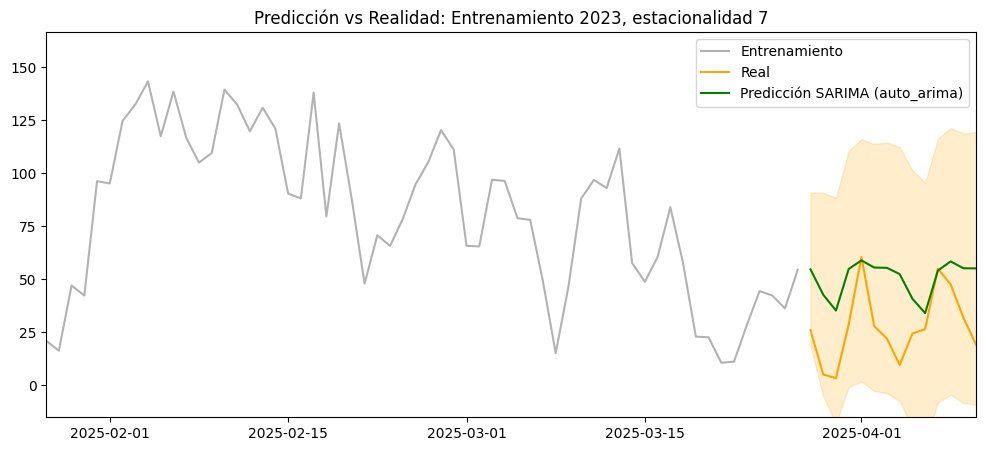

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Asume que tu DataFrame se llama df_diario y tiene columnas 'Fecha' y 'Precio'
df = df_diario.copy()
serie = df['Precio'].asfreq('D')
serie = serie[serie.index >= '2023-01-01']

split = int(len(serie) * 0.97)
train, test = serie.iloc[:-14], serie.iloc[-14:]

# Usar auto_arima para encontrar los mejores parámetros
auto_model = pm.auto_arima(train,
                           seasonal=True,
                           m=7,              # Periodo estacional (7 para datos diarios con estacionalidad semanal)
                           stepwise=True,    # Para acelerar la búsqueda
                           suppress_warnings=True,
                           trace=False)       # Para mostrar el progreso

print(auto_model.summary())

# Ajustar modelo SARIMA con los mejores parámetros encontrados
modelo = SARIMAX(train,
                 order=auto_model.order,
                 seasonal_order=auto_model.seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)
resultado = modelo.fit(disp=False)

# Predicción
pred = resultado.get_forecast(steps=len(test))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(train, label='Entrenamiento', color='grey', alpha=0.6)
plt.plot(test, label='Real', color='orange')
plt.plot(pred_mean, label='Predicción SARIMA (auto_arima)', color='green')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.legend()
plt.title('Predicción vs Realidad: Entrenamiento 2023, estacionalidad 7')

# Zoom: mostrar solo los últimos 30 días
inicio_zoom = test.index[0] - pd.Timedelta(days=60)  # 2 semanas antes del inicio de test
fin_zoom = test.index[-1]  # fin exacto de test (2 semanas)
plt.xlim(inicio_zoom, fin_zoom)

# Ajustar margen vertical con padding
y_min = min(train.min(), test.min(), pred_mean.min())
y_max = max(train.max(), test.max(), pred_mean.max())
padding = (y_max - y_min) * 0.1
plt.ylim(y_min - padding, y_max + padding)

plt.show()


## Modelo GARCH para obtener volatilidad

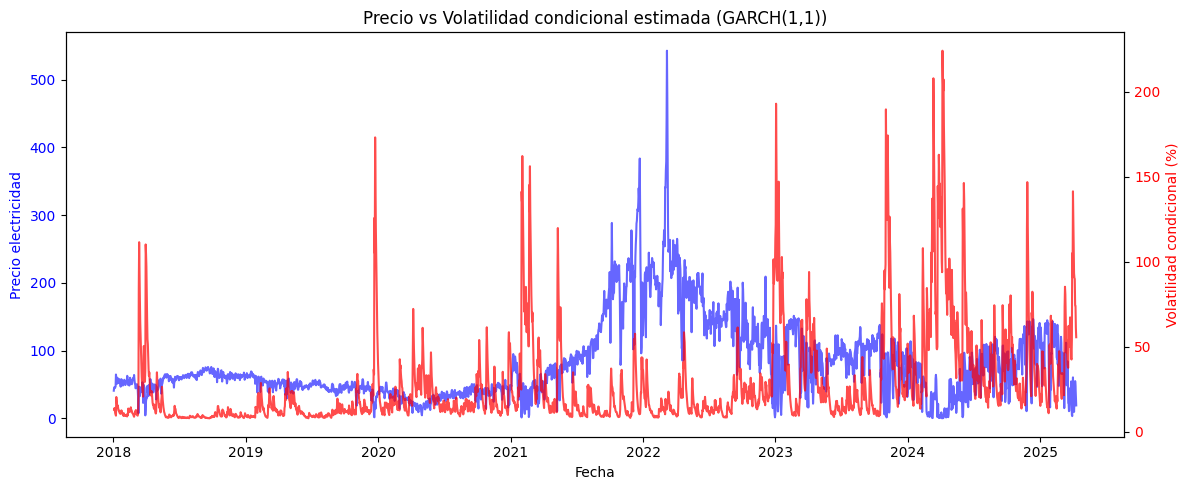

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import numpy as np

df_diario_log = 100 * np.log(df_diario / df_diario.shift(1)).dropna()

precio_alineado = df_diario.loc[df_diario_log.index]

# 5. Crear y ajustar el modelo GARCH(1,1)
model = arch_model(df_diario_log, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='t')
resultado = model.fit(disp='off')

volatilidad_condicional = resultado.conditional_volatility

# Ya tienen el mismo índice
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(precio_alineado.index, precio_alineado, label='Precio', color='blue', alpha=0.6)
ax1.set_ylabel('Precio electricidad', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Fecha')

ax2 = ax1.twinx()
ax2.plot(volatilidad_condicional.index, volatilidad_condicional, label='Volatilidad', color='red', alpha=0.7)
ax2.set_ylabel('Volatilidad condicional (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Precio vs Volatilidad condicional estimada (GARCH(1,1))')
fig.tight_layout()
plt.show()

## Modelo SARIMA- GARCH

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=25.42 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26645.045, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=26582.497, Time=1.15 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=26590.977, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26643.047, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=26647.041, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=26570.746, Time=3.55 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=11.41 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=6.36 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=26569.008, Time=1.82 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=26580.594, Time=0.72 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=9.23 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=26570.430, Time=2.56 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=26234

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


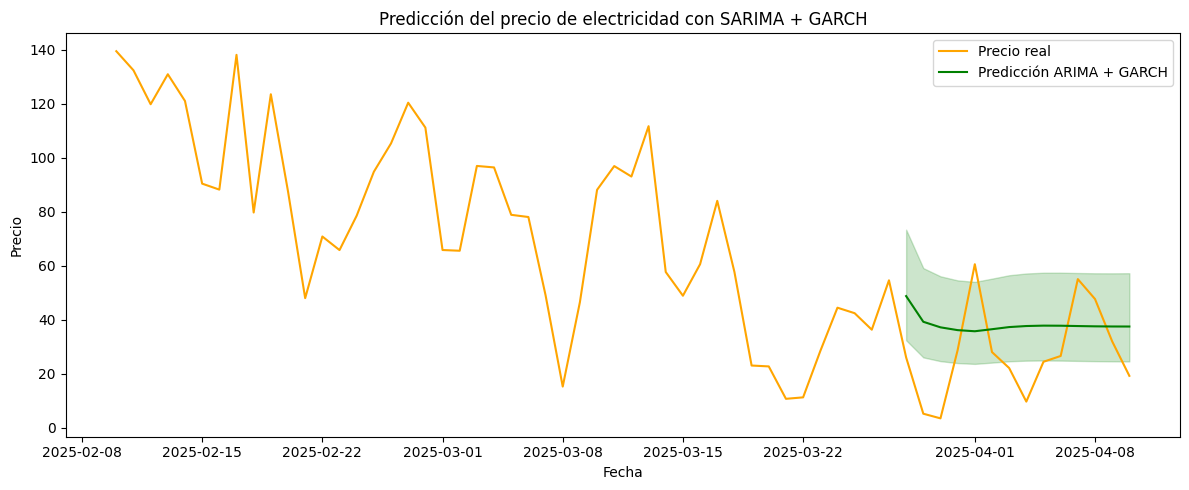

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

warnings.simplefilter(action='ignore', category=FutureWarning)


df = df_diario.copy()
serie = df['Precio'].asfreq('D')
serie = serie[serie.index >= '2024-01-01']

# === 1. Calcular retornos logarítmicos ===
df_logret = 100 * np.log(df_diario / df_diario.shift(1)).dropna()
retornos = df_logret['Precio']

# === 2. Dividir en entrenamiento y test ===
split = int(len(retornos) * 0.97)
train_ret, test_ret = retornos.iloc[:-14], retornos.iloc[-14:]

# === 3. Ajustar modelo ARIMA sobre los retornos ===
auto_model = pm.auto_arima(train_ret,
                           seasonal=True,
                           m=7,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True)

modelo_arima = SARIMAX(train_ret,
                       order=auto_model.order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
resultado_arima = modelo_arima.fit(disp=False)

# === 4. Extraer residuos y ajustar modelo GARCH ===
residuos_arima = resultado_arima.resid
modelo_garch = arch_model(residuos_arima,
                          vol='GARCH',
                          p=1, q=1,
                          mean='Zero',
                          dist='t')
resultado_garch = modelo_garch.fit(disp='off')

# === 5. Predecir retornos futuros con ARIMA ===
forecast_arima = resultado_arima.get_forecast(steps=14)
retornos_predichos = forecast_arima.predicted_mean

# === 6. Predecir volatilidad condicional futura con GARCH ===
forecast_garch = resultado_garch.forecast(horizon=14)
volatilidad_predicha = np.sqrt(forecast_garch.variance.values[-1, :])

# === 7. Reconstruir precios desde retornos predichos ===
precio_base = df_diario['Precio'].iloc[-15]  # último precio conocido
precios_predichos = [precio_base]

for r in retornos_predichos:
    nuevo_precio = precios_predichos[-1] * np.exp(r / 100)
    precios_predichos.append(nuevo_precio)

precios_predichos = pd.Series(precios_predichos[1:], index=test_ret.index)

# === 8. Visualizar ===
plt.figure(figsize=(12, 5))
plt.plot(df_diario['Precio'].iloc[-60:], label='Precio real', color='orange')
plt.plot(precios_predichos, label='Predicción ARIMA + GARCH', color='green')

# Banda de volatilidad: intervalo aproximado con +-1 desviación estándar
upper = precios_predichos * np.exp(volatilidad_predicha / 100)
lower = precios_predichos * np.exp(-volatilidad_predicha / 100)
plt.fill_between(precios_predichos.index, lower, upper, color='green', alpha=0.2)

plt.title('Predicción del precio de electricidad con SARIMA + GARCH')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.tight_layout()
plt.show()

## Modelo LSTM in-sample predicition

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0136
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0022
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0020
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0018
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0016
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0012
Epoch 15/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
Epoc

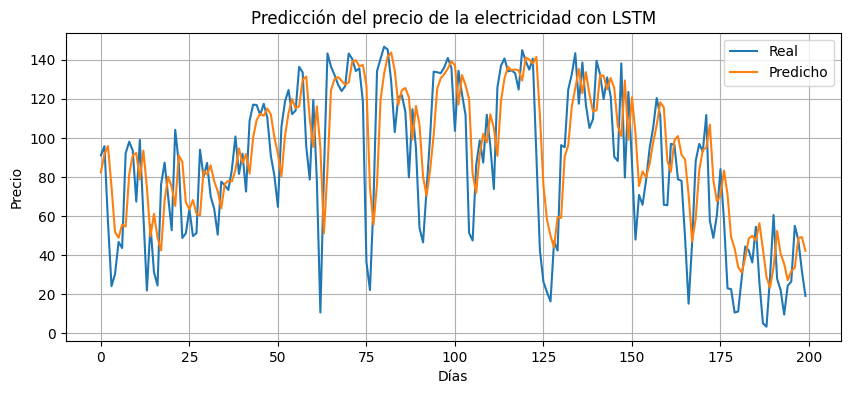

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Suponemos que df_diario es una serie con índice datetime y precios como valores
serie = df_diario.copy()
serie.index = pd.to_datetime(serie.index)

# Normalizar
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

# Crear secuencias
def crear_secuencias(series, ventana):
    X, y = [], []
    for i in range(len(series) - ventana):
        X.append(series[i:i+ventana])
        y.append(series[i+ventana])
    return np.array(X), np.array(y)

ventana = 30
X, y = crear_secuencias(serie_scaled, ventana)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Crear modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ventana, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32)

# Predicción
y_pred = model.predict(X)
y_real = scaler.inverse_transform(y.reshape(-1, 1))
y_pred_real = scaler.inverse_transform(y_pred)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_real, y_pred_real))
mae = mean_absolute_error(y_real, y_pred_real)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

# Visualización
plt.figure(figsize=(10,4))
plt.plot(y_real[-200:], label='Real')
plt.plot(y_pred_real[-200:], label='Predicho')
plt.legend()
plt.title("Predicción del precio de la electricidad con LSTM")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.grid(True)
plt.show()

## Modelo LSTM out-of-sample prediciton

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


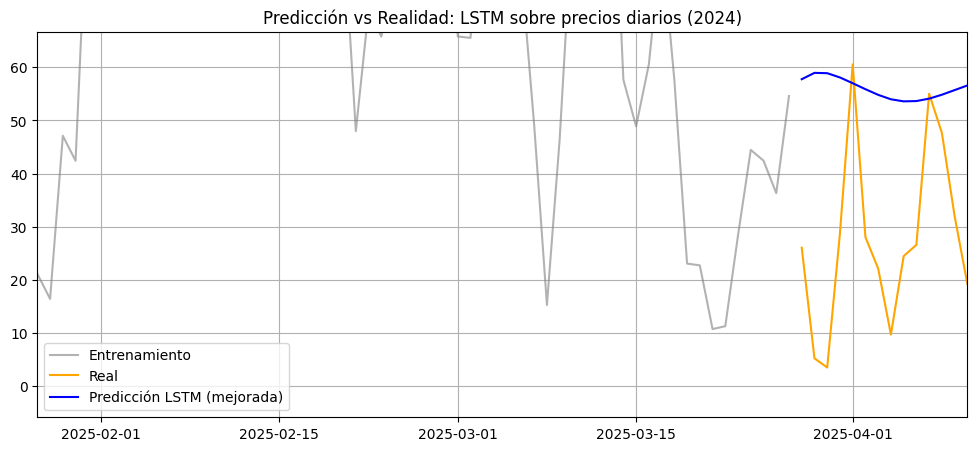

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- Preparación de datos ---
df = df_diario.copy()
serie = df['Precio'].asfreq('D')
serie = serie[serie.index >= '2024-01-01']

split = int(len(serie) * 0.97)
train, test = serie.iloc[:-14], serie.iloc[-14:]

# Normalizar solo sobre entrenamiento
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

# Crear secuencias para LSTM
ventana = 30
def crear_secuencias(datos, ventana):
    X, y = [], []
    for i in range(len(datos) - ventana):
        X.append(datos[i:i+ventana])
        y.append(datos[i+ventana])
    return np.array(X), np.array(y)

X_train, y_train = crear_secuencias(train_scaled, ventana)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# --- Modelo LSTM mejorado ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(ventana, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# --- Predicción autorregresiva 14 días ---
preds_scaled = []
input_seq = train_scaled[-ventana:].copy()

for _ in range(14):
    input_reshaped = input_seq.reshape((1, ventana, 1))
    pred_scaled = model.predict(input_reshaped, verbose=0)[0, 0]
    preds_scaled.append(pred_scaled)
    input_seq = np.append(input_seq[1:], [[pred_scaled]], axis=0)

# Desnormalizar predicciones
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

# --- Visualización ---
plt.figure(figsize=(12, 5))
plt.plot(train, label='Entrenamiento', color='grey', alpha=0.6)
plt.plot(test, label='Real', color='orange')
plt.plot(test.index, preds, label='Predicción LSTM (mejorada)', color='blue')

# Zoom
inicio_zoom = test.index[0] - pd.Timedelta(days=60)
fin_zoom = test.index[-1]
plt.xlim(inicio_zoom, fin_zoom)

# Límites del eje Y con padding
y_min = min(train.min(), test.min(), min(preds))
y_max = max(test.max(), max(preds))
padding = (y_max - y_min) * 0.1
plt.ylim(y_min - padding, y_max + padding)

plt.legend()
plt.title('Predicción vs Realidad: LSTM sobre precios diarios (2024)')
plt.grid(True)
plt.show()

In [ ]:
%%capture
!pip install --upgrade --force-reinstall numpy==1.26.4 pandas==2.2.2 pmdarima

In [ ]:
import numpy as np
import pandas as pd
import pmdarima as pm

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("pmdarima:", pm.__version__)

numpy: 1.26.4
pandas: 2.2.2
pmdarima: 2.0.4
